# MNIST Classification - Neural Network

In [4]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

import pickle
from tqdm import tqdm

In [2]:
# Importing data
dl_path = './MNIST'

# Run first time to download dataset
#mnist = fetch_openml('mnist_784', version=1, data_home=dl_path)

# After fetching and processing for the first time
#with open('./MNIST/mnist_processed.pkl', 'wb') as f:
#    pickle.dump(mnist, f)

# Pickled data for quick retrieval
with open('./MNIST/mnist_processed.pkl', 'rb') as f:
    mnist = pickle.load(f)

### Prepping data
- Resampling (undersampling to ensure equal distribution of labels)
- Splitting into train/test
- Scaling data to normalize
- Applying PCA

In [5]:
# Splitting into train/test data
X, y = mnist["data"], mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

# Undersampling training set to remove sampling bias
unique, counts = np.unique(y_train, return_counts=True)
min_samples = min(counts)

sample_ids = []
for u in unique :
    class_samples = y_train[y_train == u].index.to_numpy()

    random_indices = np.random.choice(len(class_samples), min_samples, replace=False)
    sample_ids.extend(class_samples[random_indices])

X_train, y_train = X_train.iloc[sample_ids], y_train.iloc[sample_ids]

## Fully connected network
For a fully connected network we will use PCA to reduce the dimensionality of the input layer

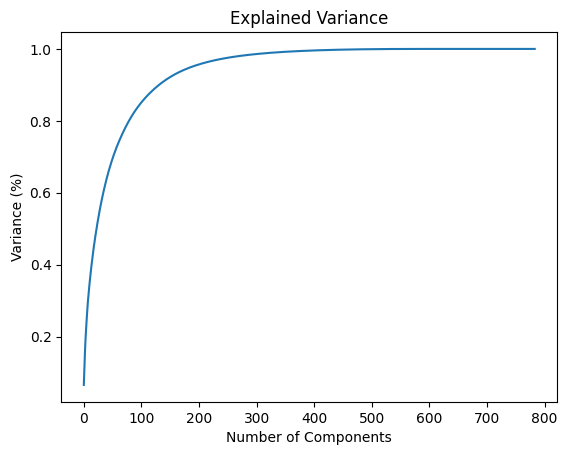

Number of components for 95% variance:  188


In [36]:
# Scaling features
scaler = StandardScaler()
train_features = scaler.fit_transform(X_train)
test_features = scaler.transform(X_test)

# Applying PCA and visualizing explained variance
pca = PCA().fit(train_features)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

# Keeping modes for 95% variance
pca_95 = PCA(0.95)  # 0.95 is the explained variance we want to preserve
train_features = pca_95.fit_transform(train_features)
test_features = pca_95.transform(test_features)

print("Number of components for 95% variance: ", pca_95.n_components_)

In [37]:
# Convert data into PyTorch tensors
X_train_tensor = torch.tensor(train_features, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.astype(np.int64))
X_test_tensor = torch.tensor(test_features, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.astype(np.int64))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [38]:
# Defining fully connected network 
class FCN(nn.Module):
    def __init__(self, input_dim):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)
    

def train_model(model, train_loader, test_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validate
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {100 * correct / total:.2f}%")

In [40]:
# Training model 
model = FCN(train_features.shape[1])
train_model(model, train_loader, test_loader, num_epochs=10)

Epoch 1/10, Accuracy: 83.20%
Epoch 2/10, Accuracy: 87.23%
Epoch 3/10, Accuracy: 87.66%
Epoch 4/10, Accuracy: 88.07%
Epoch 5/10, Accuracy: 88.17%
Epoch 6/10, Accuracy: 88.19%
Epoch 7/10, Accuracy: 88.23%
Epoch 8/10, Accuracy: 88.17%
Epoch 9/10, Accuracy: 88.30%
Epoch 10/10, Accuracy: 88.28%


## Convolutional Network

In [42]:
train_features = X_train.values.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0
test_features = X_test.values.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0

# Convert data and labels to tensors
train_data = TensorDataset(torch.tensor(train_features), torch.tensor(y_train.values.astype(np.int64)))
test_data = TensorDataset(torch.tensor(test_features), torch.tensor(y_test.values.astype(np.int64)))

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [43]:
# Defining network architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)  # The dimension here is dependent on the output size of your layers.
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*7*7)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [44]:
# Training model 
model = CNN()
train_model(model, train_loader, test_loader, num_epochs=15)

Epoch 1/15, Accuracy: 63.80%
Epoch 2/15, Accuracy: 82.31%
Epoch 3/15, Accuracy: 88.55%
Epoch 4/15, Accuracy: 90.49%
Epoch 5/15, Accuracy: 91.07%
Epoch 6/15, Accuracy: 91.40%
Epoch 7/15, Accuracy: 91.42%
Epoch 8/15, Accuracy: 92.47%
Epoch 9/15, Accuracy: 92.90%
Epoch 10/15, Accuracy: 93.20%
Epoch 11/15, Accuracy: 93.68%
Epoch 12/15, Accuracy: 93.38%
Epoch 13/15, Accuracy: 93.64%
Epoch 14/15, Accuracy: 94.07%
Epoch 15/15, Accuracy: 94.43%
